# About this dataset
Resale transacted prices of flats from different types and locations in Singapore

# Additional Libraries that do not come pre-installed with Anaconda

In [1]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

# Import necessary libraries

In [2]:
%matplotlib inline
# all the basic libraries that we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style= 'darkgrid')

# pre-processing method
from sklearn.model_selection import train_test_split

# the regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# methods and classes for evaluation
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import cross_validate
import time

# Import data

In [3]:
df = pd.read_csv('/content/resale-flat-prices-singapore (1).csv')  # import the csv file
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


# Get to know the data
### ( shape, dtypes, missing/garbage values, outliers, descriptive statistics, distributions, univariate and bivariate analysis)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50432 entries, 0 to 50431
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                50432 non-null  object 
 1   town                 50432 non-null  object 
 2   flat_type            50432 non-null  object 
 3   block                50432 non-null  object 
 4   street_name          50432 non-null  object 
 5   storey_range         50432 non-null  object 
 6   floor_area_sqm       50432 non-null  float64
 7   flat_model           50432 non-null  object 
 8   lease_commence_date  50432 non-null  int64  
 9   remaining_lease      50432 non-null  object 
 10  resale_price         50432 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 4.2+ MB


In [5]:
df.isna().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

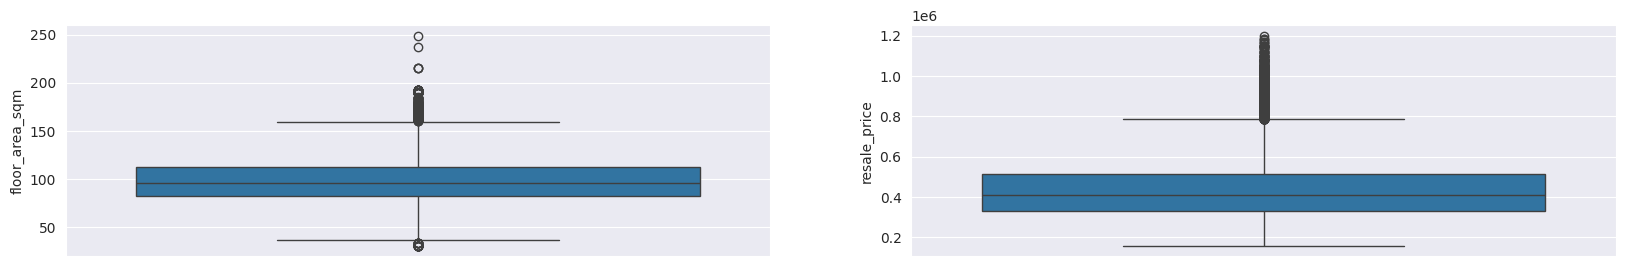

In [6]:
numeric_col = df.columns[pd.Series(df.columns).apply(lambda x : df[x].dtype == 'float64')]  # Non object columns

plt.figure(figsize = (20,3))

j = 1
for i in numeric_col:
    plt.subplot(1,2,j)
    sns.boxplot(df[i])
    j += 1

#### Both the variables seem to be right skewed. And, looking at the outliers in the resale price, there are a lot of mansions among the commons

In [7]:
from datetime import datetime
df.month = df.month.apply(lambda x: datetime.strptime(x, "%Y-%m"))    # Converting dtype of month column from object to datetime

In [8]:
remaining_years = df.remaining_lease.apply(lambda x: int(x[0:2])) #pull out numbers from individual strings of "remaining_lease"
lease_duration = (df.month.apply(lambda x: x.year) - df.lease_commence_date) + remaining_years
lease_duration.value_counts()
# All the leases seem to be 100year leases. So we need only one of the three columns["remaining_lease",
#                                                                                   "Lease_commence_date", "month"]

99     28579
98     21794
100       59
dtype: int64

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
encoded_df = pd.DataFrame()
object_col = df.columns[pd.Series(df.columns).apply(lambda x : df[x].dtype == 'O')]
for i in df.columns:
    if i in object_col:
        encoded_df[i] = le.fit_transform(df[i])
    else:
        encoded_df[i] = df[i]

#Encode the categorical variables

In [10]:
encoded_df.dtypes

month                  datetime64[ns]
town                            int64
flat_type                       int64
block                           int64
street_name                     int64
storey_range                    int64
floor_area_sqm                float64
flat_model                      int64
lease_commence_date             int64
remaining_lease                 int64
resale_price                  float64
dtype: object

In [11]:
# convert data type of categorical columns as "category" type
for i in df.columns:
    if df[i].dtype == 'O':
        encoded_df[i] = encoded_df[i].astype('category')
    else:
        pass

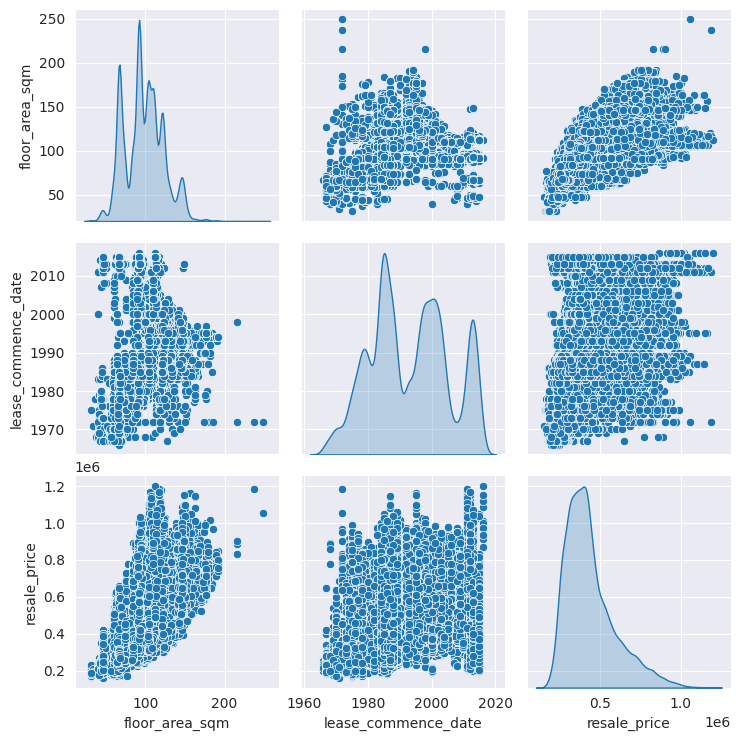

In [12]:
sns.pairplot(df, diag_kind= 'kde')
plt.show()

* There seems to be a slight correlation of "floor_area_sqm" and "resale_price"
* Resale_price is right skewed as we inferred from the boxplot earlier

# Pick out X(predictor(s)) and y(response)

In [13]:
encoded_df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')

In [14]:
# drop "month" and "lease" along with the target column, because all are 100 year leases.
X = encoded_df.drop(columns= ['month', 'remaining_lease', 'resale_price'])
y = encoded_df.resale_price

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

# Train and evaluate models

In [16]:
def fit_n_print(model, X_train, X_test, y_train, y_test):  # take the model, train data and test data as input

    start = time.time()  # note the start time

    model.fit(X_train, y_train)   # fit the model using the train data

    pred = model.predict(X_test)     # model predictions on the test data

    r2 = metrics.r2_score(y_test, pred)  # calculate the r squared value on the test data

    rmse = sqrt(metrics.mean_squared_error(y_test, pred))   # Root mean squared error

    rmsle = sqrt(metrics.mean_squared_log_error(y_test, pred))  # Root mean squared log error (since the numbers are huge)

    scorer = {'r2' : metrics.make_scorer(metrics.r2_score),
              'mse' : metrics.make_scorer(metrics.mean_squared_error),
              'msle' : metrics.make_scorer(metrics.mean_squared_log_error),
               }    # make scorers to be used in cross validation

    cv = cross_validate(model, X_train, y_train, cv=10, scoring = scorer)   # perform cross validation accross 3 metrics

    r2_cv = cv['test_r2'].mean()                                     # mean r squared value
    rmse_cv = np.mean([sqrt(mse) for mse in cv['test_mse']]) # mean RMSE value(take root of individual mse value and then mean)
    rmsle_cv = np.mean([sqrt(msle) for msle in cv['test_msle']]) # mean RMSLE

    end = time.time()  #note the end time


    duration = end - start  # calculate the total duration


    return r2, rmse, rmsle, r2_cv, rmse_cv, rmsle_cv, duration, pred  # return all the metrics along with predictions

In [17]:
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=1)
br = BaggingRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1, n_estimators=100)  # specifying n_estimators to avoid "future warnings"
gb = GradientBoostingRegressor(random_state=1, n_estimators=100)


result = {}   # Create an empty dictionary to later use to store metrics of each of the models

# putting all 5 models in a for loop and appending the results of each of the models to the 'result' dictionary
for model, name  in zip([lr, dt, br, rf, gb], ['Linear Regression', 'Decision Tree',
                                                    'Bagging Ensemble', 'Random Forest', 'Gradient Boost Ensemble']):
    result[name] = fit_n_print(model,X_train, X_test,y_train, y_test)
    # store all the metrics in the result dict, with name as key

In [18]:
result1 = pd.DataFrame(result).T.iloc[:,:-1]

result1.columns = ['R squared', 'RMSE', 'RMSLE', 'CV R squared', 'CV RMSE', 'CV RMSLE', 'Elapsed']

result1.index.name = 'Model'   # name the index of the result1 dataframe as 'Model'

result1

,R squared,RMSE,RMSLE,CV R squared,CV RMSE,CV RMSLE,Elapsed
Model,,,,,,,
Linear Regression,0.572798,101139.480516,0.209603,0.573113,100452.953833,0.207289,1.467551
Decision Tree,0.937031,38829.935047,0.083684,0.936076,38863.937784,0.084249,4.245512
Bagging Ensemble,0.958115,31668.952268,0.069617,0.955902,32279.786023,0.070342,30.180933
Random Forest,0.960693,30678.664378,0.067732,0.959832,30812.718354,0.067747,166.170724
Gradient Boost Ensemble,0.832664,63299.325675,0.127729,0.839368,61623.848334,0.124478,41.982281


- **Random forest out-performed all the other models**
- However, we have few attributes which have high cardinality which can potential noisy attributes. So let's remove them
- And about the other attributes, let's one-hot encode them

In [19]:
cat_col = X.columns[pd.Series(X.columns).apply(lambda x : X[x].dtype.name == 'category')]

# check the cardinality of the columns
for i in cat_col:
    print(i, "=>" ,len(X[i].value_counts()))  # print number of categories in each of the categorical columns


town => 26
flat_type => 7
block => 2299
street_name => 533
storey_range => 17
flat_model => 20


In [20]:
one_hot_X = X.drop(columns= ['block', 'street_name']) # Because cardinality is high
one_hot_X = pd.get_dummies(one_hot_X, drop_first=True)
one_hot_X.shape

X_train, X_test, y_train, y_test = train_test_split(one_hot_X,y, random_state = 1)

In [21]:
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=1)
br = BaggingRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1, n_estimators=100)
gb = GradientBoostingRegressor(random_state=1, n_estimators=100)
xgb = XGBRegressor()
cgb = CatBoostRegressor()
lgb = LGBMRegressor()


result = {}   #Create an empty dictionary to later use to store metrics of each of the models

for model, name  in zip([lr, dt, br, rf,
                         gb, xgb, cgb, lgb], ['Linear Regression', 'Decision Tree','Bagging Ensemble', 'Random Forest',
                                              'Gradient Boost Ensemble', 'Xgboost', 'Catboost','LightGB']):
    result[name] = fit_n_print(model,X_train, X_test,y_train, y_test)

Streaming output truncated to the last 5000 lines.
66:	learn: 63397.9187356	total: 406ms	remaining: 5.66s
67:	learn: 63099.6642817	total: 412ms	remaining: 5.65s
68:	learn: 62887.6689547	total: 417ms	remaining: 5.63s
69:	learn: 62684.6972055	total: 422ms	remaining: 5.6s
70:	learn: 62458.4646604	total: 427ms	remaining: 5.58s
71:	learn: 62257.6241983	total: 432ms	remaining: 5.56s
72:	learn: 62040.6918793	total: 437ms	remaining: 5.55s
73:	learn: 61864.3183702	total: 442ms	remaining: 5.53s
74:	learn: 61686.8663690	total: 447ms	remaining: 5.51s
75:	learn: 61359.5896872	total: 452ms	remaining: 5.5s
76:	learn: 61037.1140882	total: 457ms	remaining: 5.48s
77:	learn: 60804.6465991	total: 462ms	remaining: 5.46s
78:	learn: 60493.5477119	total: 468ms	remaining: 5.45s
79:	learn: 60257.3220327	total: 473ms	remaining: 5.44s
80:	learn: 60071.5666366	total: 485ms	remaining: 5.5s
81:	learn: 59910.0048908	total: 491ms	remaining: 5.49s
82:	learn: 59735.2783001	total: 496ms	remaining: 5.48s
83:	learn: 59545.

In [22]:
result_df = pd.DataFrame(result).T.iloc[:,:-1]

result_df.columns = ['R squared', 'RMSE', 'RMSLE', 'CV R squared', 'CV RMSE', 'CV RMSLE', 'Elapsed']

result_df.index.name = "Model"
result_df

,R squared,RMSE,RMSLE,CV R squared,CV RMSE,CV RMSLE,Elapsed
Model,,,,,,,
Linear Regression,0.864321,56998.15831,0.144925,0.867013,56072.344342,0.141419,2.816725
Decision Tree,0.930057,40923.692222,0.087009,0.930186,40624.552422,0.086537,4.235646
Bagging Ensemble,0.940358,37790.255616,0.081284,0.941928,37050.418028,0.080257,23.470994
Random Forest,0.943313,36842.293733,0.079518,0.944468,36229.33898,0.07874,203.331337
Gradient Boost Ensemble,0.846007,60723.128228,0.125164,0.84818,59905.577944,0.12346,57.575186
Xgboost,0.936659,38944.544374,0.083524,0.937683,38384.094262,0.082263,8.634776
Catboost,0.938566,38353.729855,0.082949,0.938791,38038.896895,0.08233,81.372293
LightGB,0.9253,42292.464596,0.089621,0.926028,41819.735462,0.088693,4.538037


- For this dataset, Random forest and Bagging models are still the best among all the other models including the new boosting models
- Since none of the models are tuned, we cannot judge the winner yet. Because, there are a few key hyper parameters like learning rate(which is specific to the boosting algorithms), max depth, number of estimators etc that can turn the table around
- One noticeable point is that LightGB has given a close performance to Random forest but the time taken was far less even compared to the bagging model which by default has only 10 estimators
- The Decision tree model has surprisingly outperformed all the boosting models accross all the metrics including the CV scores
- Complicated models do not always guarantee better performance. The good old Linear regression did a fairly good job with far less computation

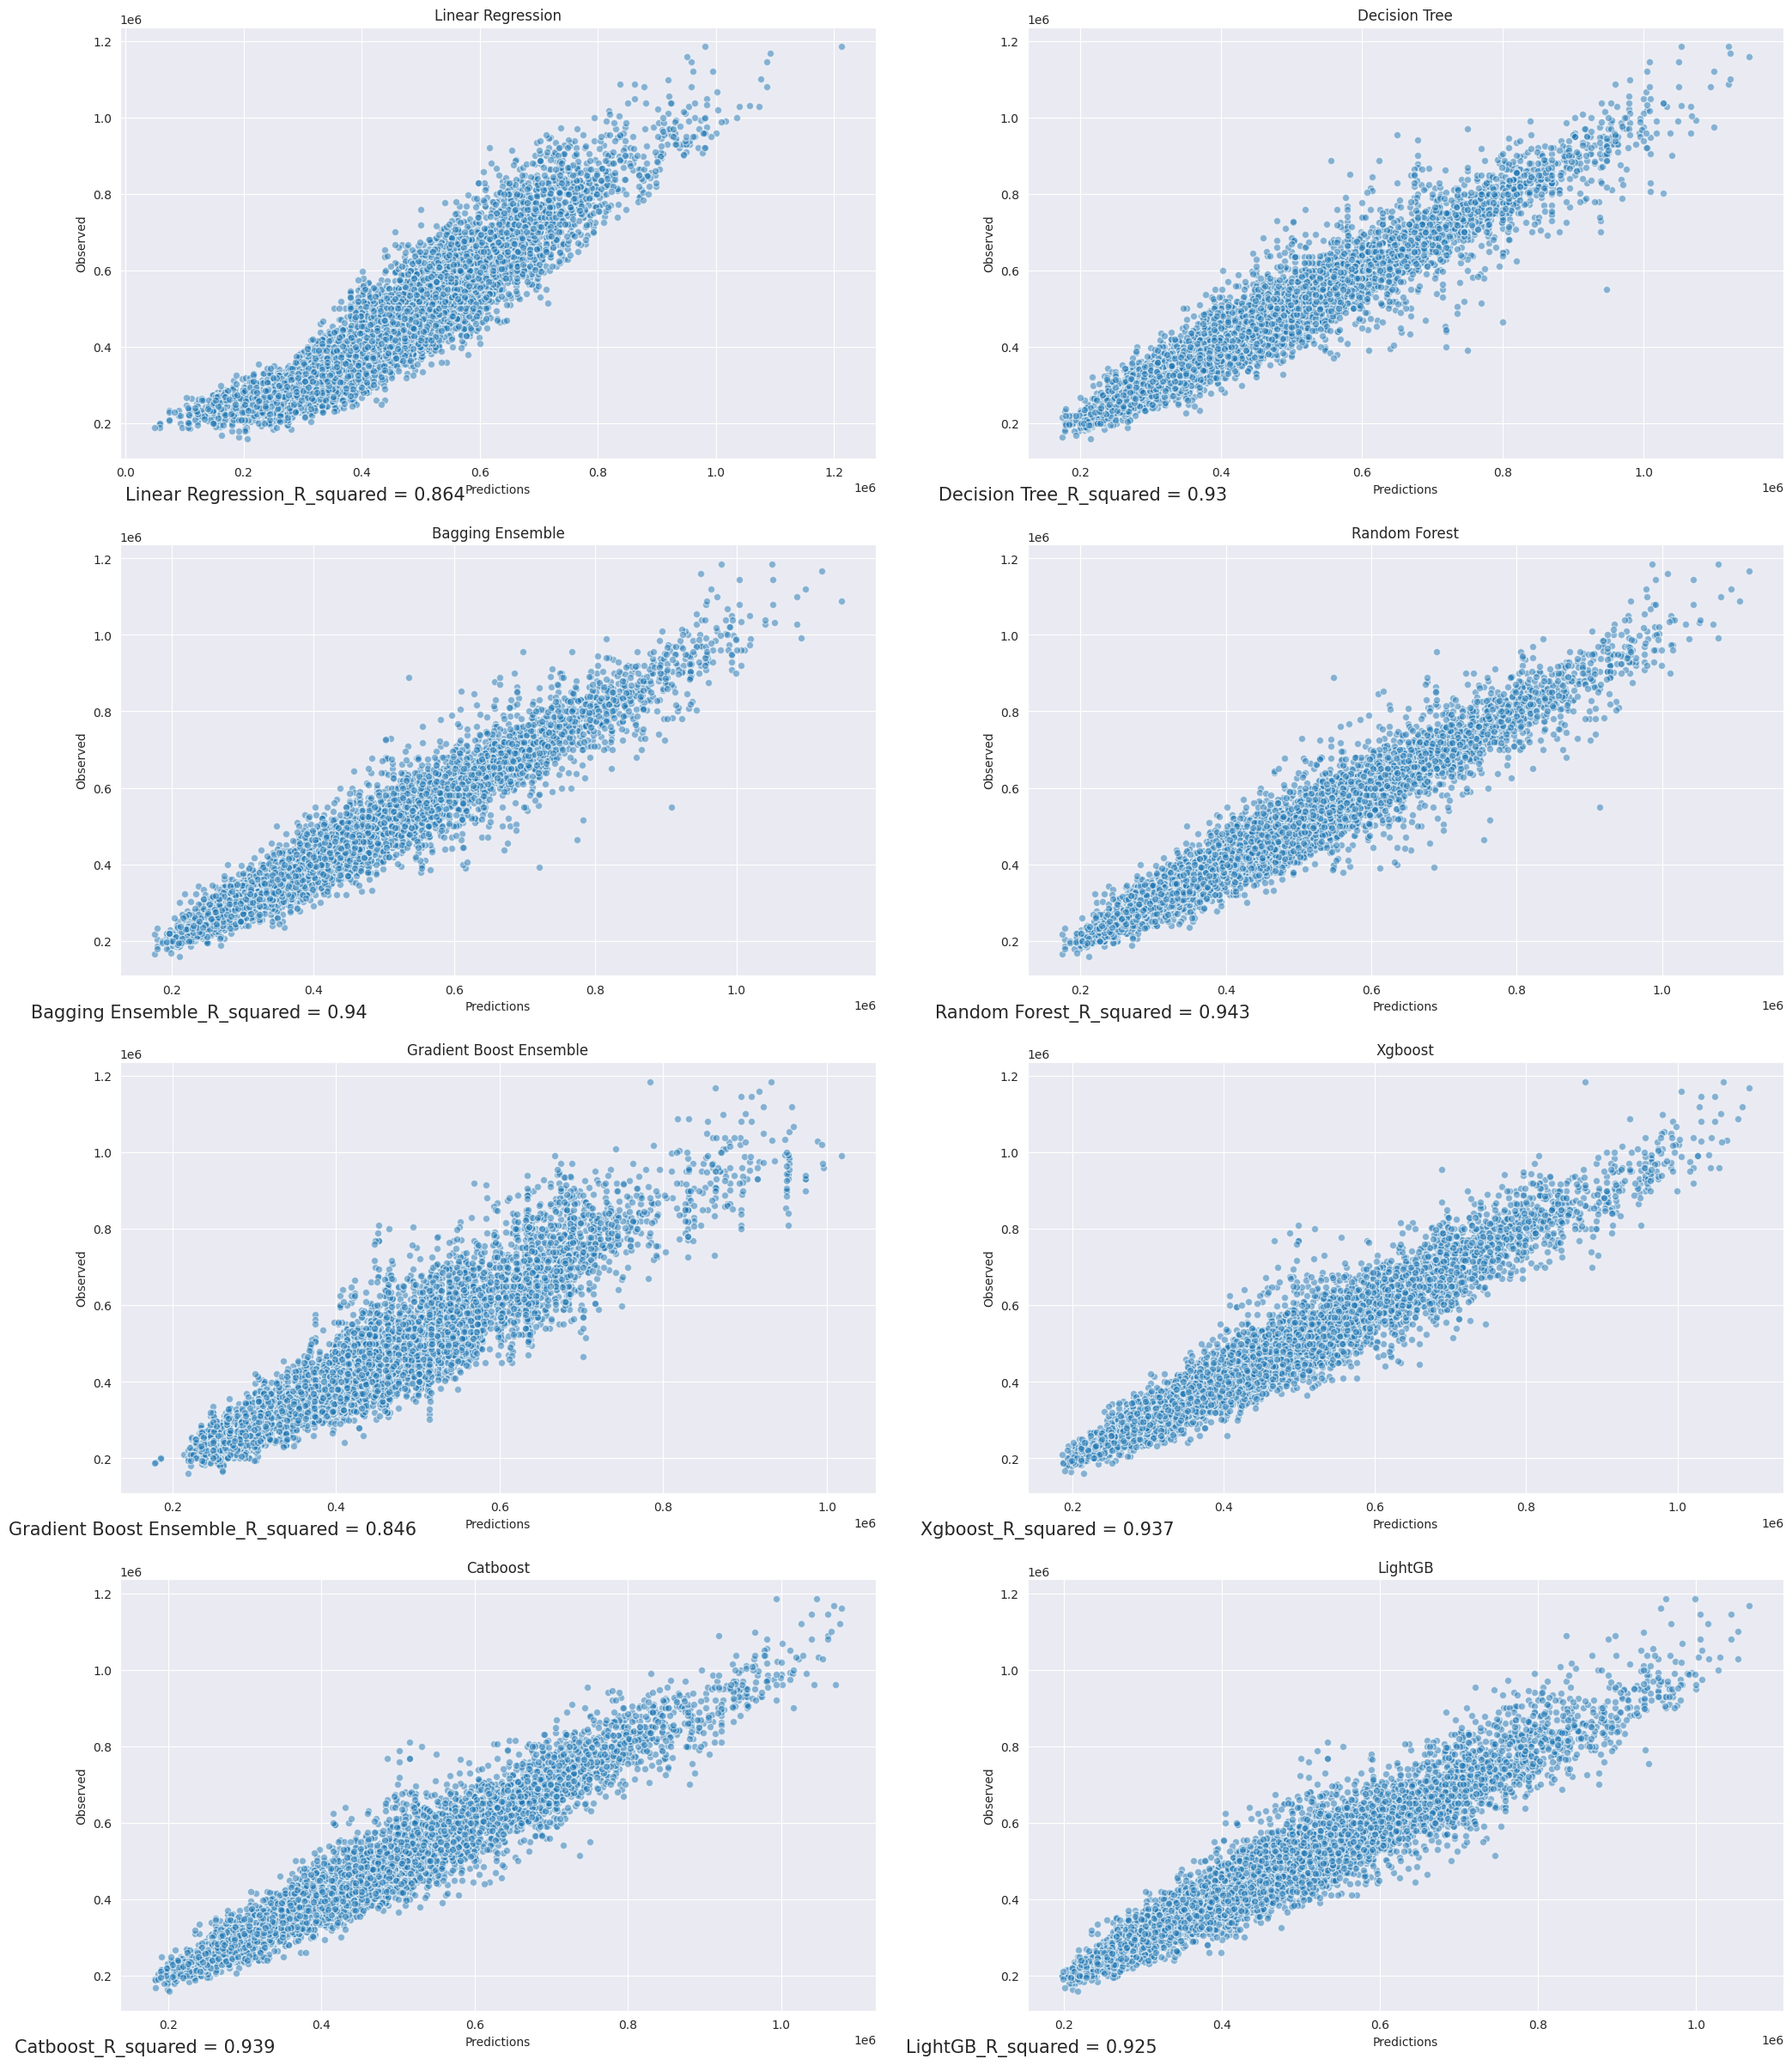

In [23]:
plt.figure(figsize= (25,30))

results = list(result.values())
results = [i for i in results]

for pos in range(1,9):
    plt.subplot(4, 2, pos)
    plt.scatter(results[pos-1][-1], y_test, alpha= 0.5, edgecolors='white')
    plt.xlabel('Predictions')
    plt.ylabel('Observed')
    plt.title(list(result.keys())[pos-1])
    plt.text(0, 0, f'{list(result.keys())[pos-1]}_R_squared = {round(results[pos-1][0], 3)}',
             fontsize = 15)
    pos += 1

- Apart from the numbers, we can use some visuals to compare the performances of the models
- In each of the plots, the x axis is the predictions and y-axis
- The closer the swarm of points is to the diagonal, the better the predictions are

# Final Remarks
- Xgboost, Catboost and Lightgb are libraries which contain implimentations of the classic Gradient Boosting algorithm
- These libraries have tried to regularize the Gradient Boosting algorithm and improvise GBM for various aspects like computing speed, computing resources, leveraging GPUs etc
- We have seen Random forest (with 100 estimators), even though it gave a good performance, took a long time to process, where as all the new boosting algos took lesser time  for the same number of estimators and specifically LightGBM was relatively super fast
- However, the new boosting algos have not performed the best
- Maybe they are not as good with Regression as they are with Classification
- One major advantage of the GBM variants are the processing capability. They can handle very large datasets in relatively less time, optimal resource usage and apparently better performance compared to the traditional algorithms. Allbeit, we cannot show case it here since we are limited with the datasize hardware resources

# Reference links
- [Xgboost](https://xgboost.readthedocs.io/en/latest/)
- [Catboost](https://catboost.ai/)
- [lightGBM](https://lightgbm.readthedocs.io/en/latest/)